# Data visualization and analysis of interpolated image data

The worms we collect image data from can vary in length. As such, the resulting vectors of data can vary in length. One way to handle this is by standardizing all the vector lengths and interpolating some data points. 

Below is a workflow for analyzing this type of data.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import random
import re
from statistics import mean
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
import seaborn as sns
import researchpy as rp
from scipy.stats import ks_2samp
from scipy.stats import chisquare

---

In [4]:
# read in a pandas dataframe containing our image arrays along with some metadata 
data = pd.read_pickle("/Volumes/onishlab_shared/PROJECTS/30_Andrew/03_IMAGING_DATABASE/IMDB.pkl")
data

,date,strain,feed,temp,name,stage,rating,comments,ID,array_vals,array_vals_ni,REP
0,230614,N2,JUB66_RFP,25,image1,YL4,4,comments,00021,"[0.011764705882352941, 0.011764705882352941, 0...","[0.011764705882352941, 0.011764705882352941, 0...",1
1,230614,N2,JUB66_RFP,25,image2,YL4,4,comments,00022,"[0.010910200656137941, 0.01151731697290573, 0....","[0.010910200656137941, 0.011764705882352941, 0...",1
2,230614,N2,JUB66_RFP,25,image3,YL4,5,comments,00023,"[0.011764705882352941, 0.011764705882352941, 0...","[0.011764705882352941, 0.011764705882352941, 0...",1
3,230614,N2,JUB66_RFP,25,image4,YL4,4,comments,00024,"[0.011444266422522316, 0.011697760685114819, 0...","[0.011444266422522316, 0.011764705882352941, 0...",1
4,230614,N2,JUB66_RFP,25,image5,YL4,4,Lots of signal in this one all concentrated n...,00025,"[0.011764705882352941, 0.014485120414898868, 0...","[0.011764705882352941, 0.015030136568245976, 0...",1
...,...,...,...,...,...,...,...,...,...,...,...,...
85,230721,N2,MK_JUB66_RFP_IN_JUB66,25,image6,L4,4,comments,00106,"[0.011764705882352941, 0.011764705882352941, 0...","[0.011764705882352941, 0.011764705882352941, 0...",3
86,230721,N2,MK_JUB66_RFP_IN_JUB66,25,image7,YL4,4,comments,00107,"[0.011764705882352941, 0.011764705882352941, 0...","[0.011764705882352941, 0.011764705882352941, 0...",3
87,230721,N2,MK_JUB66_RFP_IN_JUB66,25,image8,L4,3,comments,00108,"[0.011764705882352941, 0.011764705882352941, 0...","[0.011764705882352941, 0.011764705882352941, 0...",3
88,230721,N2,MK_JUB66_RFP_IN_JUB66,25,image9,L4,4,comments,00109,"[0.011764705882352941, 0.011764705882352941, 0...","[0.011764705882352941, 0.011764705882352941, 0...",3


In [61]:
# make an array of the interpolated data
arr_data = data["array_vals"].values
arr_data

# make an array of the strain names
arr_diet = data["feed"].values
arr_diet

# make an array of the image REP
arr_rep = data["REP"].values
arr_rep

# make an array of the image IDs
arr_ID = data["ID"].values
arr_ID

# make an dataframe of the above
df = pd.DataFrame({'diet':arr_diet, 'data':arr_data, 'rep':arr_rep, 'ID':arr_ID})
print(df)

                     diet                                               data   
0               JUB66_RFP  [0.011764705882352941, 0.011764705882352941, 0...  \
1               JUB66_RFP  [0.010910200656137941, 0.01151731697290573, 0....   
2               JUB66_RFP  [0.011764705882352941, 0.011764705882352941, 0...   
3               JUB66_RFP  [0.011444266422522316, 0.011697760685114819, 0...   
4               JUB66_RFP  [0.011764705882352941, 0.014485120414898868, 0...   
..                    ...                                                ...   
85  MK_JUB66_RFP_IN_JUB66  [0.011764705882352941, 0.011764705882352941, 0...   
86  MK_JUB66_RFP_IN_JUB66  [0.011764705882352941, 0.011764705882352941, 0...   
87  MK_JUB66_RFP_IN_JUB66  [0.011764705882352941, 0.011764705882352941, 0...   
88  MK_JUB66_RFP_IN_JUB66  [0.011764705882352941, 0.011764705882352941, 0...   
89  MK_JUB66_RFP_IN_JUB66  [0.011764705882352941, 0.011764705882352941, 0...   

    rep     ID  
0     1  00021  
1    

In [62]:
# check how long the arrays are
arr_data[0].shape

(3500,)

In [63]:
# split the sample array values into their respective groups 

JUB66_RFP = df[df['diet'] == 'JUB66_RFP']
JUB66_RFP = JUB66_RFP[['data', 'diet', 'rep', 'ID']]
JUB66_RFP_arr = np.array(JUB66_RFP['data'])
JUB66_RFP['data'] = JUB66_RFP_arr

JUB66_RFP_IN_CEMBIO = df[df['diet'] == 'JUB66_RFP_IN_CEMBIO']
JUB66_RFP_IN_CEMBIO = JUB66_RFP_IN_CEMBIO[['data', 'diet', 'rep', 'ID']]
JUB66_RFP_IN_CEMBIO_arr = np.array(JUB66_RFP_IN_CEMBIO['data'])
JUB66_RFP_IN_CEMBIO['data'] = JUB66_RFP_IN_CEMBIO_arr

MK_JUB66_RFP = df[df['diet'] == 'MK_JUB66_RFP_IN_JUB66']
MK_JUB66_RFP = MK_JUB66_RFP[['data', 'diet', 'rep', 'ID']]
MK_JUB66_RFP_arr = np.array(MK_JUB66_RFP['data'])
MK_JUB66_RFP['data'] = MK_JUB66_RFP_arr

print(MK_JUB66_RFP)

                                                 data                   diet   
20  [0.01095597772182803, 0.013186978424314324, 0....  MK_JUB66_RFP_IN_JUB66  \
21  [0.011764705882352941, 0.011764705882352941, 0...  MK_JUB66_RFP_IN_JUB66   
22  [0.013626306553749905, 0.014331021301511709, 0...  MK_JUB66_RFP_IN_JUB66   
23  [0.011764705882352941, 0.011764705882352941, 0...  MK_JUB66_RFP_IN_JUB66   
24  [0.011764705882352941, 0.011764705882352941, 0...  MK_JUB66_RFP_IN_JUB66   
25  [0.008178835736629282, 0.010840311806490484, 0...  MK_JUB66_RFP_IN_JUB66   
26  [0.010681315327687495, 0.01143627713183505, 0....  MK_JUB66_RFP_IN_JUB66   
27  [0.012008850232700085, 0.013545585063236087, 0...  MK_JUB66_RFP_IN_JUB66   
28  [0.011596856641489281, 0.011720285077254413, 0...  MK_JUB66_RFP_IN_JUB66   
29  [0.011764705882352941, 0.011764705882352941, 0...  MK_JUB66_RFP_IN_JUB66   
50  [1.5259021893143654e-05, 1.5259021893143654e-0...  MK_JUB66_RFP_IN_JUB66   
51  [0.011764705882352941, 0.01176470588

In [107]:
# loop through each sample in the JUB66_RFP group and split the array into 3rds, representing the Anterior, Middle, and Posterior regions

new_array = []

# Loop through each sample in JUB66_RFP
for index, sample in enumerate(JUB66_RFP['data']):
    
    # Split the sample into three parts
    split_sample = np.array_split(sample, len(sample) % 13)
    
    # Append the split sample along with the part label to the new array
    for part_index, part in enumerate(split_sample):
        part_label = f"Part {part_index+1} of Sample {index+1}"
        new_array.append((part_label, part))
               
new_JUB66_RFP_df = pd.DataFrame(new_array) 

new_JUB66_RFP_df.columns = ['part_ID', 'part_values']

# Create a new column to store the row sums
new_JUB66_RFP_df['row_sum'] = 0

# Iterate through each sample in the dataframe
for index, row in new_JUB66_RFP_df.iterrows():
    
    # Calculate the sum of the array or row
    row_sum = sum(row['part_values'])
    
    # Assign the row sum to the 'row_sum' column
    new_JUB66_RFP_df.at[index, 'row_sum'] = row_sum

# Add a few more columns for REP, an arbitrary sample ID, and diet to our new df
rep1 = ['Rep 1'] * 30
rep2 = ['Rep 2'] * 30
rep3 = ['Rep 3'] * 30
rep_seq = rep1 + rep2 + rep3
new_JUB66_RFP_df['REP'] = rep_seq

sample_ID = [num for num in range(1, 31) for _ in range(3)]
#print(sample_ID)
#len(sample_ID)
new_JUB66_RFP_df['sample_ID'] = sample_ID

mono = ['JUB66_RFP'] * 90
new_JUB66_RFP_df['diet'] = mono

# Print the updated dataframe
print(new_JUB66_RFP_df)
new_JUB66_RFP_df.shape

                part_ID                                        part_values   
0    Part 1 of Sample 1  [0.011764705882352941, 0.011764705882352941, 0...  \
1    Part 2 of Sample 1  [0.025523367770359757, 0.023906077166038122, 0...   
2    Part 3 of Sample 1  [0.02475842807478648, 0.019767319322377477, 0....   
3    Part 1 of Sample 2  [0.010910200656137941, 0.01151731697290573, 0....   
4    Part 2 of Sample 2  [0.01298466010397897, 0.011976413363632319, 0....   
..                  ...                                                ...   
85  Part 2 of Sample 29  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
86  Part 3 of Sample 29  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
87  Part 1 of Sample 30  [0.011764705882352941, 0.011764705882352941, 0...   
88  Part 2 of Sample 30  [0.011602674170843437, 0.011702954596254842, 0...   
89  Part 3 of Sample 30  [0.011764705882352941, 0.011743162707683157, 0...   

      row_sum    REP  sample_ID       diet  
0   25.579351  Rep

(90, 6)

In [113]:
# loop through each sample in the JUB66_RFP_IN_CEMBIO group and split the array into 3rds, representing the Anterior, Middle, and Posterior regions

new_array = []

# Loop through each sample in JUB66_RFP_IN_CEMBIO
for index, sample in enumerate(JUB66_RFP_IN_CEMBIO['data']):
    
    # Split the sample into three parts
    split_sample = np.array_split(sample, len(sample) % 13)
    
    # Append the split sample along with the part label to the new array
    for part_index, part in enumerate(split_sample):
        part_label = f"Part {part_index+1} of Sample {index+1}"
        new_array.append((part_label, part))
               
new_JUB66_RFP_IN_CEMBIO_df = pd.DataFrame(new_array) 

new_JUB66_RFP_IN_CEMBIO_df.columns = ['part_ID', 'part_values']

# Create a new column to store the row sums
new_JUB66_RFP_IN_CEMBIO_df['row_sum'] = 0

# Iterate through each sample in the dataframe
for index, row in new_JUB66_RFP_IN_CEMBIO_df.iterrows():
    
    # Calculate the sum of the array or row
    row_sum = sum(row['part_values'])
    
    # Assign the row sum to the 'row_sum' column
    new_JUB66_RFP_IN_CEMBIO_df.at[index, 'row_sum'] = row_sum

# Add a few more columns for REP, an arbitrary sample ID, and diet to our new df
rep1 = ['Rep 1'] * 30
rep2 = ['Rep 2'] * 30
rep3 = ['Rep 3'] * 30
rep_seq = rep1 + rep2 + rep3
new_JUB66_RFP_IN_CEMBIO_df['REP'] = rep_seq

sample_ID = [num for num in range(31, 61) for _ in range(3)]
#print(sample_ID)
#len(sample_ID)
new_JUB66_RFP_IN_CEMBIO_df['sample_ID'] = sample_ID

comm = ['JUB66_RFP_IN_CEMBIO'] * 90
new_JUB66_RFP_IN_CEMBIO_df['diet'] = comm

# Print the updated dataframe
print(new_JUB66_RFP_IN_CEMBIO_df)
new_JUB66_RFP_IN_CEMBIO_df.shape

                part_ID                                        part_values   
0    Part 1 of Sample 1  [0.011764705882352941, 0.027729681041306353, 0...  \
1    Part 2 of Sample 1  [0.011764705882352941, 0.011764705882352941, 0...   
2    Part 3 of Sample 1  [0.015588959541634561, 0.017733364531687883, 0...   
3    Part 1 of Sample 2  [0.6690318150606546, 0.5840002941035829, 0.457...   
4    Part 2 of Sample 2  [0.016155845942141332, 0.017308632557236053, 0...   
..                  ...                                                ...   
85  Part 2 of Sample 29  [0.01568627450980392, 0.015383004175211108, 0....   
86  Part 3 of Sample 29  [0.012402226857784117, 0.011764705882352941, 0...   
87  Part 1 of Sample 30  [0.010589761196307317, 0.011638111384885321, 0...   
88  Part 2 of Sample 30  [0.011764705882352941, 0.011832745682190707, 0...   
89  Part 3 of Sample 30  [0.015015906734450859, 0.014911435420202004, 0...   

      row_sum    REP  sample_ID                 diet  
0   27.0

(90, 6)

In [114]:
# loop through each sample in the MK_JUB66_RFP group and split the array into 3rds, representing the Anterior, Middle, and Posterior regions

new_array = []

# Loop through each sample in MK_JUB66_RFP
for index, sample in enumerate(MK_JUB66_RFP['data']):
    
    # Split the sample into three parts
    split_sample = np.array_split(sample, len(sample) % 13)
    
    # Append the split sample along with the part label to the new array
    for part_index, part in enumerate(split_sample):
        part_label = f"Part {part_index+1} of Sample {index+1}"
        new_array.append((part_label, part))
               
new_MK_JUB66_RFP_df = pd.DataFrame(new_array) 

new_MK_JUB66_RFP_df.columns = ['part_ID', 'part_values']

# Create a new column to store the row sums
new_MK_JUB66_RFP_df['row_sum'] = 0

# Iterate through each sample in the dataframe
for index, row in new_MK_JUB66_RFP_df.iterrows():
    
    # Calculate the sum of the array or row
    row_sum = sum(row['part_values'])
    
    # Assign the row sum to the 'row_sum' column
    new_MK_JUB66_RFP_df.at[index, 'row_sum'] = row_sum

# Add a few more columns for REP, an arbitrary sample ID, and diet to our new df
rep1 = ['Rep 1'] * 30
rep2 = ['Rep 2'] * 30
rep3 = ['Rep 3'] * 30
rep_seq = rep1 + rep2 + rep3
new_MK_JUB66_RFP_df['REP'] = rep_seq

sample_ID = [num for num in range(61, 91) for _ in range(3)]
#print(sample_ID)
#len(sample_ID)
new_MK_JUB66_RFP_df['sample_ID'] = sample_ID

mk = ['MK_JUB66_RFP'] * 90
new_MK_JUB66_RFP_df['diet'] = mk

# Print the updated dataframe
print(new_MK_JUB66_RFP_df)
new_MK_JUB66_RFP_df.shape  

                part_ID                                        part_values   
0    Part 1 of Sample 1  [0.01095597772182803, 0.013186978424314324, 0....  \
1    Part 2 of Sample 1  [0.02313281238535424, 0.021492670316403076, 0....   
2    Part 3 of Sample 1  [0.011764705882352941, 0.011764705882352941, 0...   
3    Part 1 of Sample 2  [0.011764705882352941, 0.011764705882352941, 0...   
4    Part 2 of Sample 2  [0.011225341541631791, 0.011637016782285747, 0...   
..                  ...                                                ...   
85  Part 2 of Sample 29  [0.011764705882352941, 0.011764705882352941, 0...   
86  Part 3 of Sample 29  [0.011764705882352941, 0.011764705882352941, 0...   
87  Part 1 of Sample 30  [0.011764705882352941, 0.011764705882352941, 0...   
88  Part 2 of Sample 30  [0.011764705882352941, 0.011764705882352941, 0...   
89  Part 3 of Sample 30  [0.01279427338807597, 0.01568627450980392, 0.0...   

      row_sum    REP  sample_ID          diet  
0   18.125678  

(90, 6)

In [115]:
# combine all the seperate DFs back into one

combined_df = pd.concat([new_JUB66_RFP_df, new_JUB66_RFP_IN_CEMBIO_df, new_MK_JUB66_RFP_df])
print(combined_df)

                part_ID                                        part_values   
0    Part 1 of Sample 1  [0.011764705882352941, 0.011764705882352941, 0...  \
1    Part 2 of Sample 1  [0.025523367770359757, 0.023906077166038122, 0...   
2    Part 3 of Sample 1  [0.02475842807478648, 0.019767319322377477, 0....   
3    Part 1 of Sample 2  [0.010910200656137941, 0.01151731697290573, 0....   
4    Part 2 of Sample 2  [0.01298466010397897, 0.011976413363632319, 0....   
..                  ...                                                ...   
85  Part 2 of Sample 29  [0.011764705882352941, 0.011764705882352941, 0...   
86  Part 3 of Sample 29  [0.011764705882352941, 0.011764705882352941, 0...   
87  Part 1 of Sample 30  [0.011764705882352941, 0.011764705882352941, 0...   
88  Part 2 of Sample 30  [0.011764705882352941, 0.011764705882352941, 0...   
89  Part 3 of Sample 30  [0.01279427338807597, 0.01568627450980392, 0.0...   

      row_sum    REP  sample_ID          diet  
0   25.579351  

In [116]:
# we need to add a new column called 'part' to assign a region for each observation

parts = ['part 1', 'part 2', 'part 3']
parts_seq = parts * 90 
#print(parts_seq)
#len(parts_seq)

combined_df = combined_df.assign(part=parts_seq)
combined_df

,part_ID,part_values,row_sum,REP,sample_ID,diet,part
0,Part 1 of Sample 1,"[0.011764705882352941, 0.011764705882352941, 0...",25.579351,Rep 1,1,JUB66_RFP,part 1
1,Part 2 of Sample 1,"[0.025523367770359757, 0.023906077166038122, 0...",33.152957,Rep 1,1,JUB66_RFP,part 2
2,Part 3 of Sample 1,"[0.02475842807478648, 0.019767319322377477, 0....",26.855949,Rep 1,1,JUB66_RFP,part 3
3,Part 1 of Sample 2,"[0.010910200656137941, 0.01151731697290573, 0....",18.363878,Rep 1,2,JUB66_RFP,part 1
4,Part 2 of Sample 2,"[0.01298466010397897, 0.011976413363632319, 0....",19.861612,Rep 1,2,JUB66_RFP,part 2
...,...,...,...,...,...,...,...
85,Part 2 of Sample 29,"[0.011764705882352941, 0.011764705882352941, 0...",18.335350,Rep 3,89,MK_JUB66_RFP,part 2
86,Part 3 of Sample 29,"[0.011764705882352941, 0.011764705882352941, 0...",15.781216,Rep 3,89,MK_JUB66_RFP,part 3
87,Part 1 of Sample 30,"[0.011764705882352941, 0.011764705882352941, 0...",18.244084,Rep 3,90,MK_JUB66_RFP,part 1
88,Part 2 of Sample 30,"[0.011764705882352941, 0.011764705882352941, 0...",17.078793,Rep 3,90,MK_JUB66_RFP,part 2


-----

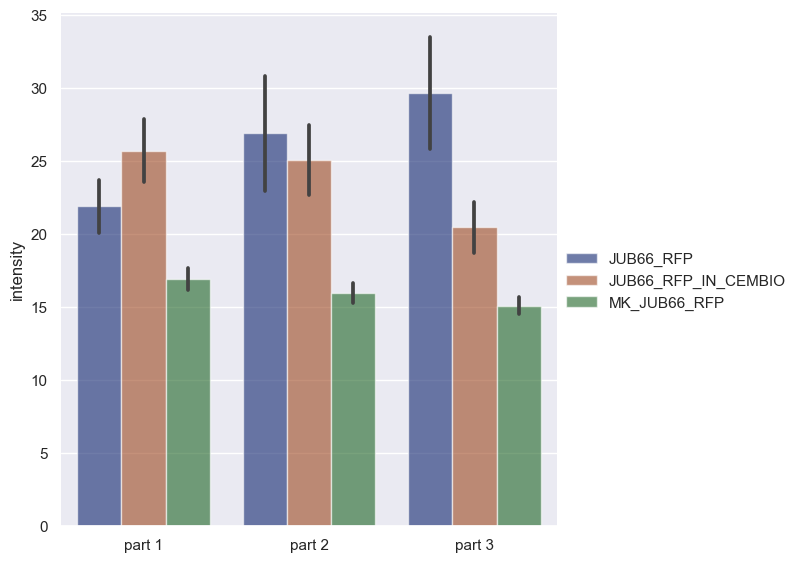

In [127]:
# graph the data as a grouped bar plot

g = sns.catplot(
    data=combined_df, kind="bar",
    x="part", y="row_sum", hue="diet",
    errorbar="se", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "intensity")
g.legend.set_title("")

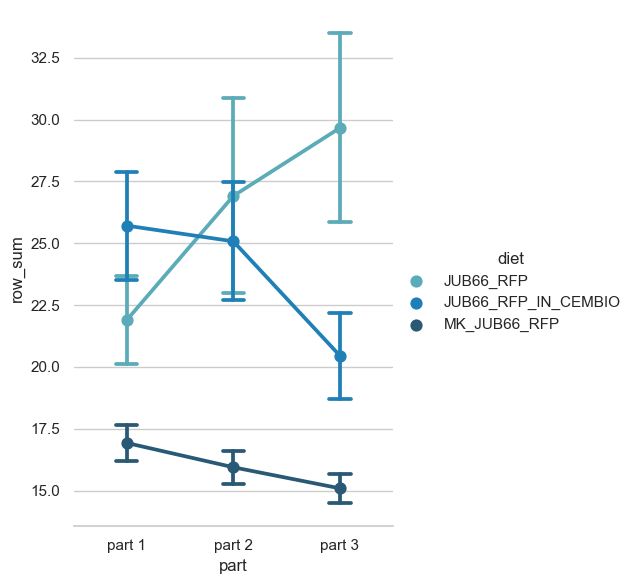

In [128]:
# graph the data as a grouped point plot

sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=combined_df, x="part", y="row_sum", hue="diet",
    capsize=.2, palette="YlGnBu_d", errorbar="se",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)

[Text(0, 0.5, '')]

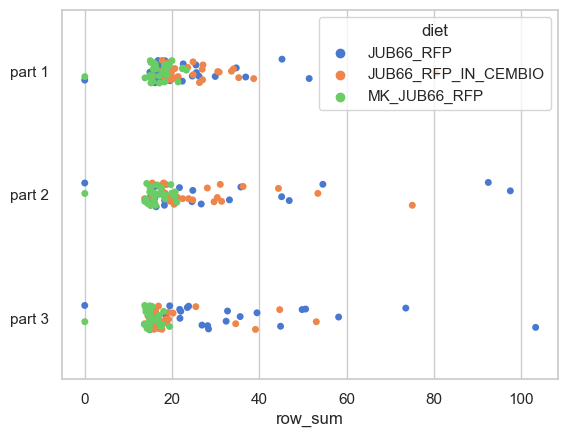

In [129]:
# Draw a categorical scatterplot to show each observation

sns.set_theme(style="whitegrid", palette="muted")

ax = sns.stripplot(data=combined_df, x="row_sum", y="part", hue="diet")
ax.set(ylabel="")

<Axes: xlabel='part', ylabel='row_sum'>

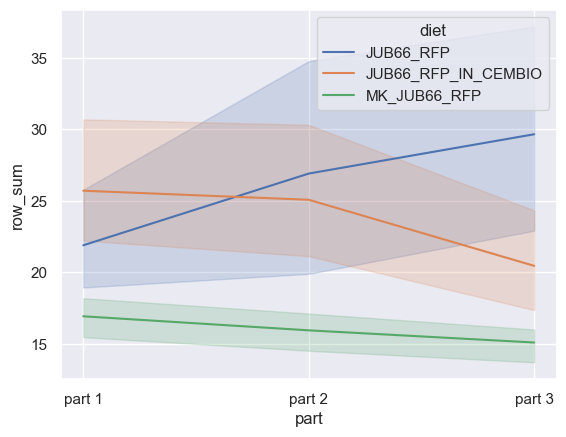

In [131]:
# Plot the responses for different each part

sns.set_theme(style="darkgrid")

sns.lineplot(x="part", y="row_sum",
             hue="diet",
             data=combined_df)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(1, 0, '(part 1, JUB66_RFP)'),
  Text(2, 0, '(part 1, JUB66_RFP_IN_CEMBIO)'),
  Text(3, 0, '(part 1, MK_JUB66_RFP)'),
  Text(4, 0, '(part 2, JUB66_RFP)'),
  Text(5, 0, '(part 2, JUB66_RFP_IN_CEMBIO)'),
  Text(6, 0, '(part 2, MK_JUB66_RFP)'),
  Text(7, 0, '(part 3, JUB66_RFP)'),
  Text(8, 0, '(part 3, JUB66_RFP_IN_CEMBIO)'),
  Text(9, 0, '(part 3, MK_JUB66_RFP)')])

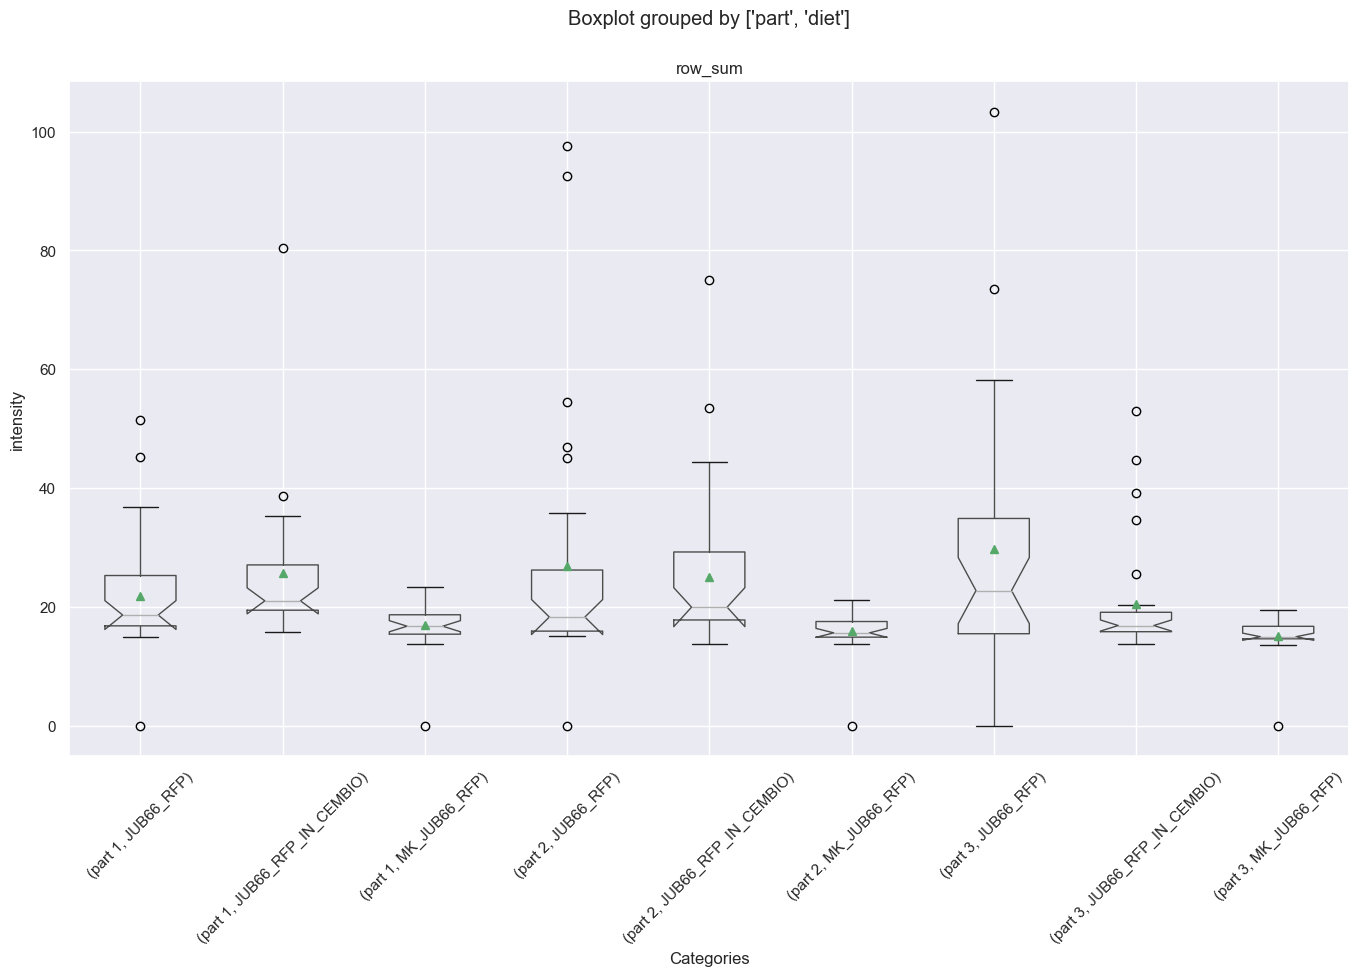

In [132]:
# graph the data as a box plot
boxplot = combined_df.boxplot(["row_sum"], by = ["part", "diet"],
                     figsize = (16, 9),
                     showmeans = True,
                     notch = True)

boxplot.set_xlabel("Categories")
boxplot.set_ylabel("intensity")
plt.xticks(rotation=45)

------

In [122]:
# lets look at the row_sum based on their diet and the part grouping.
rp.summary_cont(combined_df.groupby(["diet", "part"])["row_sum"])

N     Mean       SD      SE  95% Conf.  Interval
diet                part                                                     
JUB66_RFP           part 1  30  21.8944   9.8419  1.7969    18.2194   25.5694
                    part 2  30  26.9124  21.5881  3.9414    18.8513   34.9735
                    part 3  30  29.6628  20.9218  3.8198    21.8504   37.4751
JUB66_RFP_IN_CEMBIO part 1  30  25.7116  11.9706  2.1855    21.2417   30.1815
                    part 2  30  25.0780  13.0552  2.3835    20.2031   29.9529
                    part 3  30  20.4539   9.5474  1.7431    16.8888   24.0189
MK_JUB66_RFP        part 1  30  16.9243   4.0407  0.7377    15.4155   18.4331
                    part 2  30  15.9421   3.7085  0.6771    14.5573   17.3269
                    part 3  30  15.0898   3.1837  0.5813    13.9009   16.2786

In [228]:
# Use a linear mixed effects model to evaluate how the dependent variable (row_sum) changes in response to our fixed effects ('diet' and 'part') while accounting for random effects (sample_ID). Random effects capture the correlation within our grouping level 'sample_ID', as it is correlated to our variable 'part'.

model = smf.mixedlm("row_sum ~ C(diet) + C(part) + C(diet):C(part)", combined_df, groups = "sample_ID").fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
=============================================================================================
Model:                          MixedLM             Dependent Variable:             row_sum  
No. Observations:               270                 Method:                         REML     
No. Groups:                     90                  Scale:                          58.1291  
Min. group size:                3                   Log-Likelihood:                 -995.8234
Max. group size:                3                   Converged:                      Yes      
Mean group size:                3.0                                                          
---------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                         21.894    2.314  9.462 0.000  17.359 26.430
C(diet)[T.JUB66_RFP_IN_CEMBIO]                     3.817    3.272  1.166 0.243  -2.597 10.231
C(diet)[T.MK_JUB66_RFP]                           -4.970    3.272 -1.519 0.129 -11.384  1.444
C(part)[T.part 2]                                  5.018    1.969  2.549 0.011   1.160  8.876
C(part)[T.part 3]                                  7.768    1.969  3.946 0.000   3.910 11.627
C(diet)[T.JUB66_RFP_IN_CEMBIO]:C(part)[T.part 2]  -5.652    2.784 -2.030 0.042 -11.108 -0.195
C(diet)[T.MK_JUB66_RFP]:C(part)[T.part 2]         -6.000    2.784 -2.155 0.031 -11.457 -0.544
C(diet)[T.JUB66_RFP_IN_CEMBIO]:C(part)[T.part 3] -13.026    2.784 -4.679 0.000 -18.483 -7.570
C(diet)[T.MK_JUB66_RFP]:C(part)[T.part 3]         -9.603    2.784 -3.449 0.001 -15.059 -4.146
sample_ID Var                                    102.507    2.969                            
=============================================================================================

"""

/var/folders/8l/_h6p2fpj4651m82879j00jlc0000gn/T/ipykernel_4072/2260220986.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(model.resid, hist = False, kde_kws = {"fill" : True, "lw": 1}, fit = stats.norm)


Statistic 0.7387349605560303
p-value 2.3870800735275147e-20
LM Statistic 14.161283876619168
LM-Test p-value 0.07765726740938624
F-Statistic 1.805871658032752
F-Test p-value 0.07616696901234828


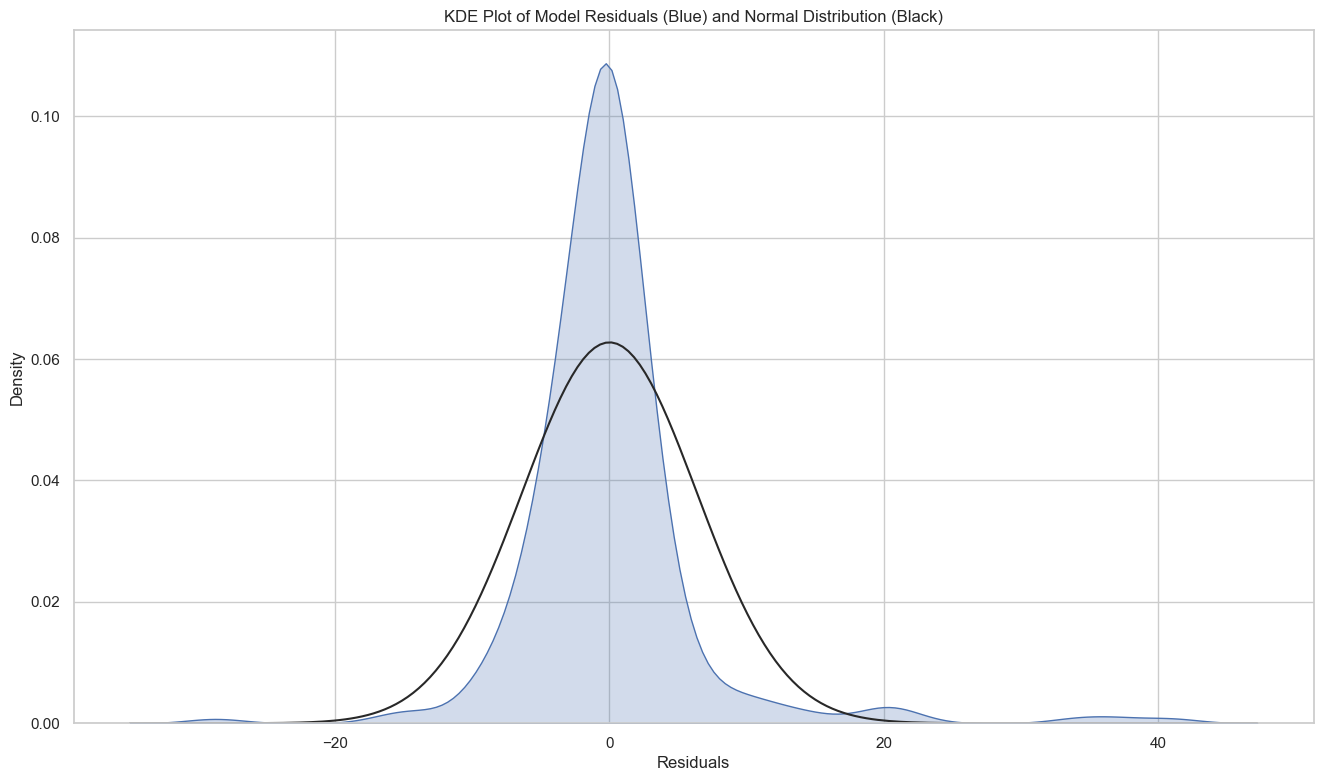

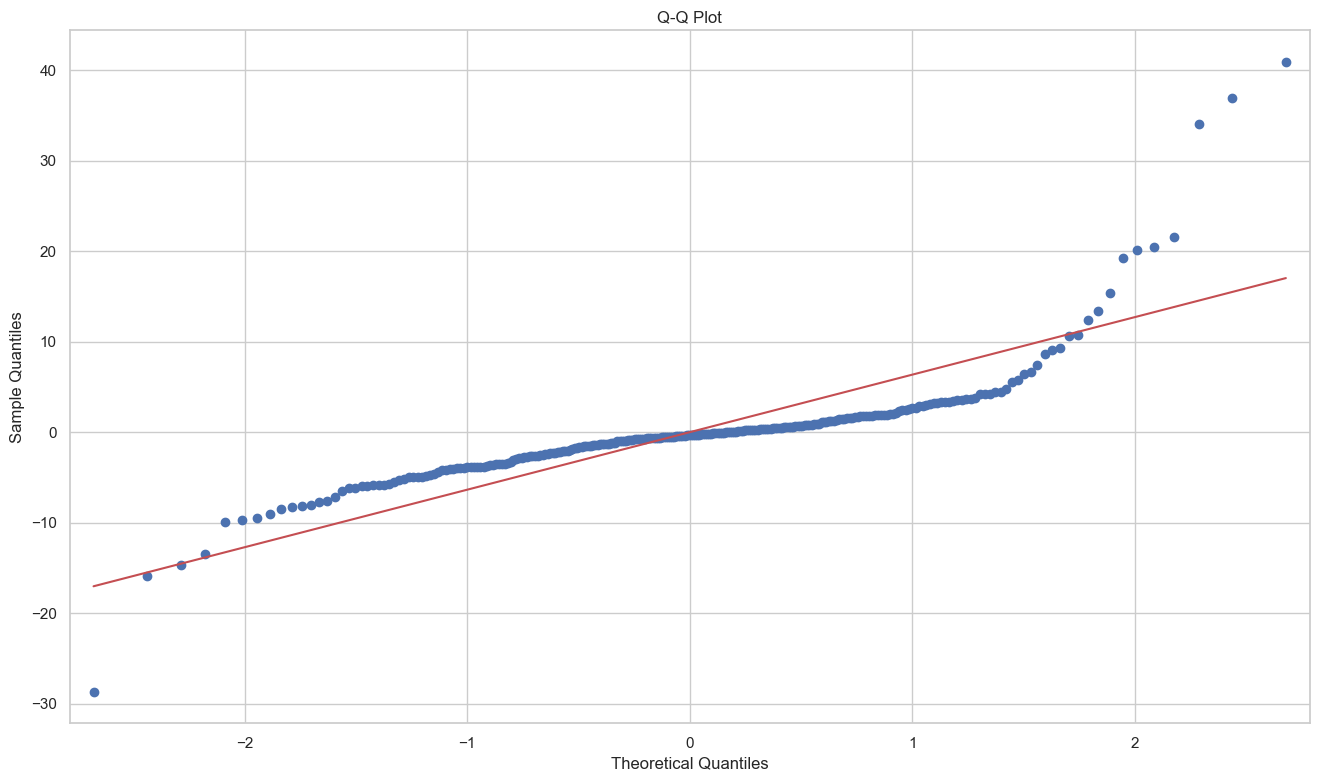

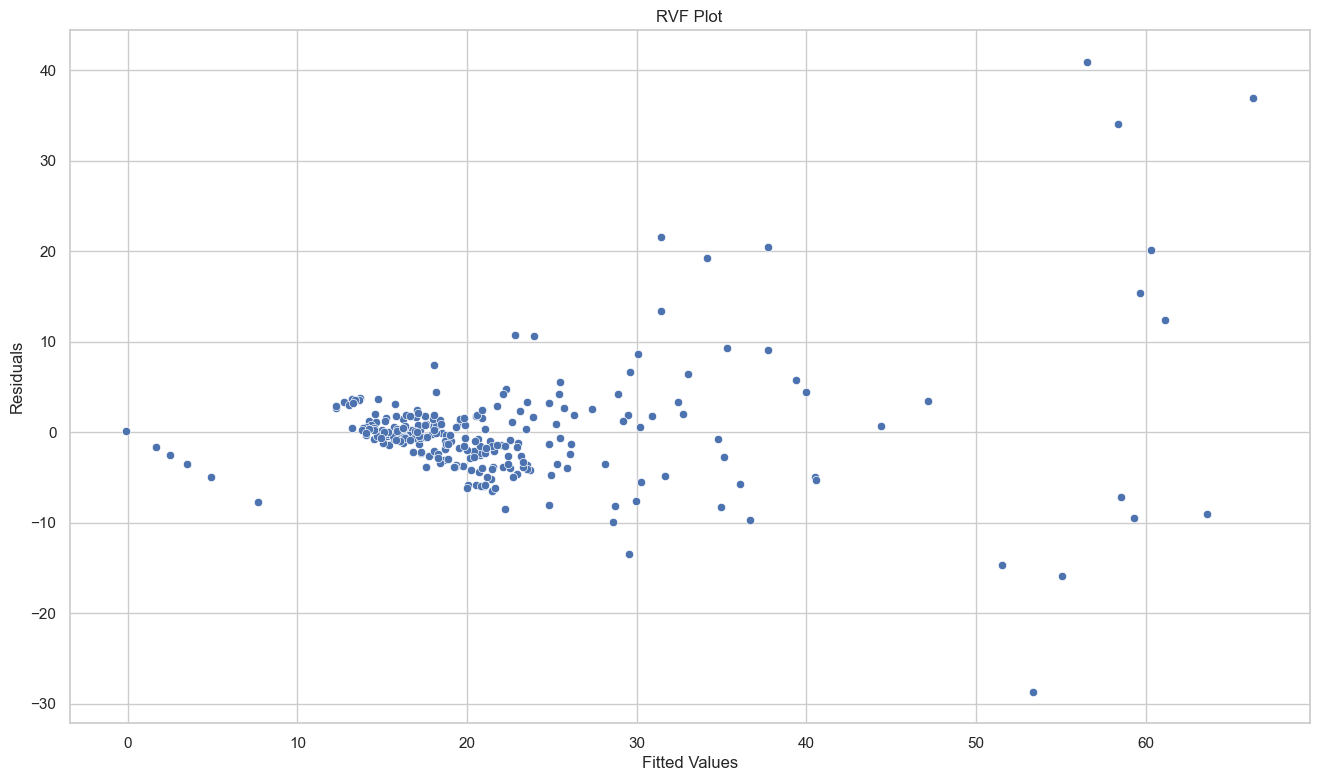

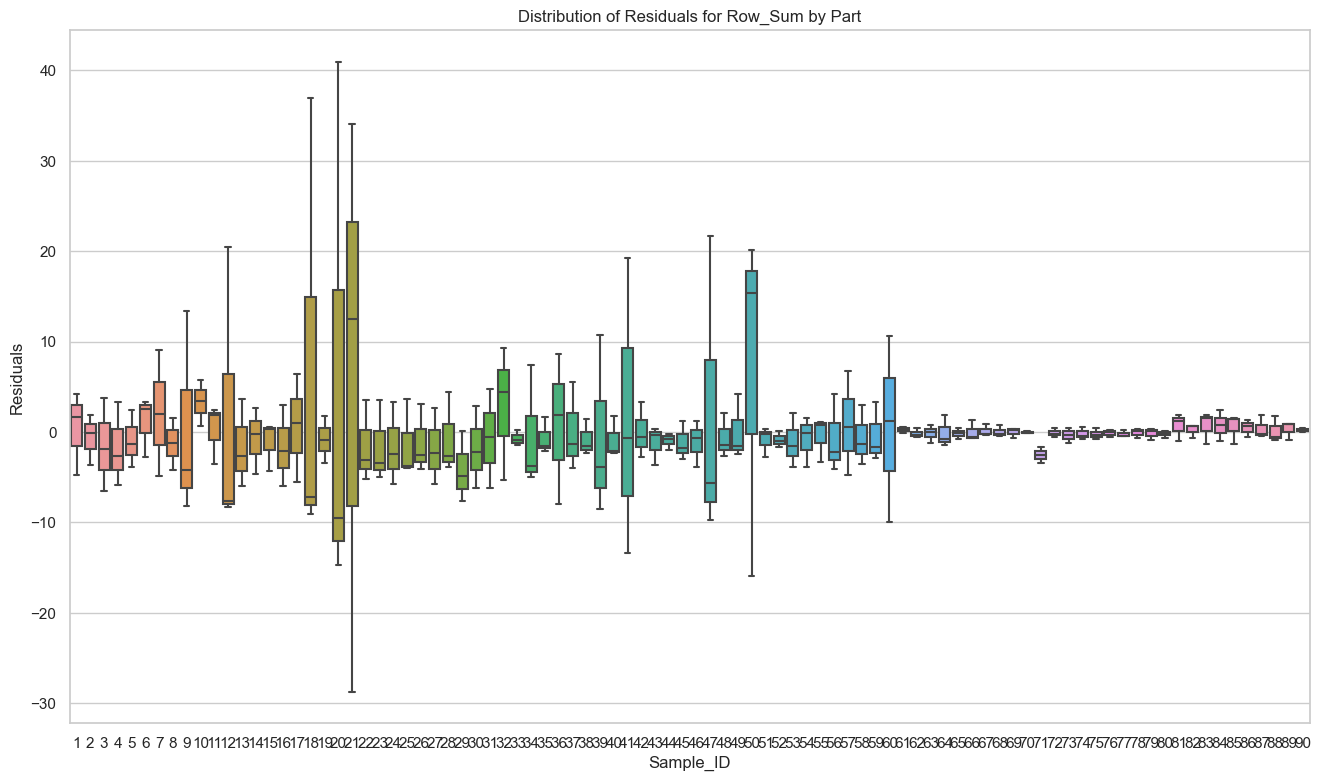

In [239]:
# Assumption check

# NORMALITY 
## kernal density estimate plot
fig = plt.figure(figsize = (16, 9))
ax = sns.distplot(model.resid, hist = False, kde_kws = {"fill" : True, "lw": 1}, fit = stats.norm)
ax.set_title("KDE Plot of Model Residuals (Blue) and Normal Distribution (Black)")
ax.set_xlabel("Residuals")

## Q-Q PLot
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)
sm.qqplot(model.resid, dist = stats.norm, line = 's', ax = ax)
ax.set_title("Q-Q Plot")

## formally test for normality using Shapir-Wilk test of normality
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(model.resid)
for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    
# HOMOSKEDASTICITY OF VARIANCE   
## RVF Plot (residuals versus fitted values)
fig = plt.figure(figsize = (16, 9))
ax = sns.scatterplot(y = model.resid, x = model.fittedvalues)
ax.set_title("RVF Plot")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")

## boxplot
fig = plt.figure(figsize = (16, 9))
ax = sns.boxplot(x = model.model.groups, y = model.resid)
ax.set_title("Distribution of Residuals for Row_Sum by Sample_ID")
ax.set_ylabel("Residuals")
ax.set_xlabel("Sample_ID")


## formally test with the White’s Lagrange Multiplier Test for Heteroscedasticity
from statsmodels.stats.diagnostic import het_white
het_white_res = het_white(model.resid, model.model.exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)

------

In [187]:
# lets test for differences in the shape of our sample distributions using the Kolmogorov-Smirnov (KS) test for goodness of fit

# use the whole length sample array (not the array split into parts) 
JUB66_RFP_arr
# then average the samples within the group
JUB66_RFP_avg = np.mean(JUB66_RFP_arr, axis=0)
print(JUB66_RFP_avg)

JUB66_RFP_IN_CEMBIO_arr
JUB66_RFP_IN_CEMBIO_avg = np.mean(JUB66_RFP_IN_CEMBIO_arr, axis=0)
print(JUB66_RFP_IN_CEMBIO_avg)

MK_JUB66_RFP_arr
MK_JUB66_RFP_avg = np.mean(MK_JUB66_RFP_arr, axis=0)
print(MK_JUB66_RFP_avg)

[0.01636276 0.02057218 0.02246784 ... 0.01414599 0.01365379 0.01301391]
[0.03363648 0.03147116 0.03051271 ... 0.01070824 0.01028531 0.00997228]
[0.01146919 0.01194542 0.01229615 ... 0.01119622 0.01101699 0.01077329]


In [144]:
# compare the sample distributions of JUB66_RFP and JUB66_RFP_IN_CEMBIO

ks_2samp(JUB66_RFP_avg, JUB66_RFP_IN_CEMBIO_avg)

KstestResult(statistic=0.2642857142857143, pvalue=7.50660759199615e-108, statistic_location=0.0192549695703017, statistic_sign=-1)

In [145]:
# compare the sample distributions of JUB66_RFP and MK_JUB66_RFP

ks_2samp(JUB66_RFP_avg, MK_JUB66_RFP_avg)

KstestResult(statistic=0.892, pvalue=0.0, statistic_location=0.015779295981485884, statistic_sign=-1)

In [146]:
# compare the sample distributions of JUB66_RFP_IN_CEMBIO and MK_JUB66_RFP

ks_2samp(JUB66_RFP_IN_CEMBIO_avg, MK_JUB66_RFP_avg)

KstestResult(statistic=0.704, pvalue=0.0, statistic_location=0.015354455398538112, statistic_sign=-1)

----

In [215]:
# Seperate out each of the groups
JUB66_RFP = combined_df[combined_df['diet'] == 'JUB66_RFP']
JUB66_RFP_IN_CEMBIO = combined_df[combined_df['diet'] == 'JUB66_RFP_IN_CEMBIO']
MK_JUB66_RFP = combined_df[combined_df['diet'] == 'MK_JUB66_RFP']

print(MK_JUB66_RFP)

                part_ID                                        part_values   
0    Part 1 of Sample 1  [0.01095597772182803, 0.013186978424314324, 0....  \
1    Part 2 of Sample 1  [0.02313281238535424, 0.021492670316403076, 0....   
2    Part 3 of Sample 1  [0.011764705882352941, 0.011764705882352941, 0...   
3    Part 1 of Sample 2  [0.011764705882352941, 0.011764705882352941, 0...   
4    Part 2 of Sample 2  [0.011225341541631791, 0.011637016782285747, 0...   
..                  ...                                                ...   
85  Part 2 of Sample 29  [0.011764705882352941, 0.011764705882352941, 0...   
86  Part 3 of Sample 29  [0.011764705882352941, 0.011764705882352941, 0...   
87  Part 1 of Sample 30  [0.011764705882352941, 0.011764705882352941, 0...   
88  Part 2 of Sample 30  [0.011764705882352941, 0.011764705882352941, 0...   
89  Part 3 of Sample 30  [0.01279427338807597, 0.01568627450980392, 0.0...   

      row_sum    REP  sample_ID          diet    part  
0   18.

In [216]:
# seperate data into groups based on diet and then by part

JUB66_RFP = combined_df[combined_df['diet'] == 'JUB66_RFP']
JUB66_RFP_part1 = JUB66_RFP[JUB66_RFP['part'] == 'part 1']
JUB66_RFP_part2 = JUB66_RFP[JUB66_RFP['part'] == 'part 2']
JUB66_RFP_part3 = JUB66_RFP[JUB66_RFP['part'] == 'part 3']

JUB66_RFP_part1 = JUB66_RFP_part1['part_values']
JUB66_RFP_part2 = JUB66_RFP_part2['part_values']
JUB66_RFP_part3 = JUB66_RFP_part3['part_values']


JUB66_RFP_part1_avg = np.mean(JUB66_RFP_part1, axis=0)
JUB66_RFP_part2_avg = np.mean(JUB66_RFP_part2, axis=0)
JUB66_RFP_part3_avg = np.mean(JUB66_RFP_part3, axis=0)

print(JUB66_RFP_part3_avg)
len(JUB66_RFP_part3_avg)

[0.03077132 0.03113644 0.03334701 ... 0.01414599 0.01365379 0.01301391]


1166

In [264]:
# random number generator
rng = np.random.default_rng()

# can fit the loc and scale parameters of the distribution to the observed data
loc, scale = np.mean(JUB66_RFP_part1_avg), np.std(JUB66_RFP_part1_avg, ddof=1)
cdf = stats.norm(loc, scale).cdf
known_params = {'loc': loc, 'scale': scale}

# Perform a goodness of fit test comparing data to a normal distribution family using Anderson-Darling Statistic
res_part1 = stats.goodness_of_fit(stats.norm, JUB66_RFP_part1_avg, statistic='ad', random_state=rng)
res_part1_alt = stats.goodness_of_fit(stats.norm, JUB66_RFP_part1_avg, statistic='ad', known_params=known_params, random_state=rng)
res_part2 = stats.goodness_of_fit(stats.norm, JUB66_RFP_part2_avg, statistic='ad', random_state=rng)
res_part3 = stats.goodness_of_fit(stats.norm, JUB66_RFP_part3_avg, statistic='ad', random_state=rng)

# retrieve the results
print(res_part1.statistic, res_part1.pvalue)
print(res_part1_alt.statistic, res_part1_alt.pvalue)
print(res_part2.statistic, res_part2.pvalue)
print(res_part3.statistic, res_part3.pvalue)

37.499898606608895 0.0001
37.499898606608895 0.0001
11.173247515232788 0.0001
8.164831104008954 0.0001


In [217]:
JUB66_RFP_IN_CEMBIO = combined_df[combined_df['diet'] == 'JUB66_RFP_IN_CEMBIO']
JUB66_RFP_IN_CEMBIO_part1 = JUB66_RFP_IN_CEMBIO[JUB66_RFP_IN_CEMBIO['part'] == 'part 1']
JUB66_RFP_IN_CEMBIO_part2 = JUB66_RFP_IN_CEMBIO[JUB66_RFP_IN_CEMBIO['part'] == 'part 2']
JUB66_RFP_IN_CEMBIO_part3 = JUB66_RFP_IN_CEMBIO[JUB66_RFP_IN_CEMBIO['part'] == 'part 3']

JUB66_RFP_IN_CEMBIO_part1 = JUB66_RFP_IN_CEMBIO_part1['part_values']
JUB66_RFP_IN_CEMBIO_part2 = JUB66_RFP_IN_CEMBIO_part2['part_values']
JUB66_RFP_IN_CEMBIO_part3 = JUB66_RFP_IN_CEMBIO_part3['part_values']


JUB66_RFP_IN_CEMBIO_part1_avg = np.mean(JUB66_RFP_IN_CEMBIO_part1, axis=0)
JUB66_RFP_IN_CEMBIO_part2_avg = np.mean(JUB66_RFP_IN_CEMBIO_part2, axis=0)
JUB66_RFP_IN_CEMBIO_part3_avg = np.mean(JUB66_RFP_IN_CEMBIO_part3, axis=0)

print(JUB66_RFP_IN_CEMBIO_part3_avg)
len(JUB66_RFP_IN_CEMBIO_part3_avg)

[0.01394868 0.0141261  0.01425607 ... 0.01070824 0.01028531 0.00997228]


1166

In [266]:
# random number generator
rng = np.random.default_rng()

# can fit the loc and scale parameters of the distribution to the observed data
loc, scale = np.mean(JUB66_RFP_IN_CEMBIO_part1_avg), np.std(JUB66_RFP_IN_CEMBIO_part1_avg, ddof=1)
cdf = stats.norm(loc, scale).cdf
known_params = {'loc': loc, 'scale': scale}

# Perform a goodness of fit test comparing data to a normal distribution family using Anderson-Darling Statistic
res_part1 = stats.goodness_of_fit(stats.norm, JUB66_RFP_IN_CEMBIO_part1_avg, statistic='ad', random_state=rng)
res_part1_alt = stats.goodness_of_fit(stats.norm, JUB66_RFP_IN_CEMBIO_part1_avg, statistic='ad', known_params=known_params, random_state=rng)
res_part2 = stats.goodness_of_fit(stats.norm, JUB66_RFP_IN_CEMBIO_part2_avg, statistic='ad', random_state=rng)
res_part3 = stats.goodness_of_fit(stats.norm, JUB66_RFP_IN_CEMBIO_part3_avg, statistic='ad', random_state=rng)

# retrieve the results
print(res_part1.statistic, res_part1.pvalue)
print(res_part1_alt.statistic, res_part1_alt.pvalue)
print(res_part2.statistic, res_part2.pvalue)
print(res_part3.statistic, res_part3.pvalue)

59.10546298287704 0.0001
59.10546298287704 0.0001
53.60685991950277 0.0001
60.23013529432319 0.0001


In [218]:
MK_JUB66_RFP = combined_df[combined_df['diet'] == 'MK_JUB66_RFP']
MK_JUB66_RFP_part1 = MK_JUB66_RFP[MK_JUB66_RFP['part'] == 'part 1']
MK_JUB66_RFP_part2 = MK_JUB66_RFP[MK_JUB66_RFP['part'] == 'part 2']
MK_JUB66_RFP_part3 = MK_JUB66_RFP[MK_JUB66_RFP['part'] == 'part 3']

MK_JUB66_RFP_part1 = MK_JUB66_RFP_part1['part_values']
MK_JUB66_RFP_part2 = MK_JUB66_RFP_part2['part_values']
MK_JUB66_RFP_part3 = MK_JUB66_RFP_part3['part_values']


MK_JUB66_RFP_part1_avg = np.mean(MK_JUB66_RFP_part1, axis=0)
MK_JUB66_RFP_part2_avg = np.mean(MK_JUB66_RFP_part2, axis=0)
MK_JUB66_RFP_part3_avg = np.mean(MK_JUB66_RFP_part3, axis=0)

print(MK_JUB66_RFP_part3_avg)
len(MK_JUB66_RFP_part3_avg)

[0.01325893 0.01326062 0.01313616 ... 0.01119622 0.01101699 0.01077329]


1166

In [269]:
# random number generator
rng = np.random.default_rng()

# can fit the loc and scale parameters of the distribution to the observed data
loc, scale = np.mean(MK_JUB66_RFP_part1_avg), np.std(MK_JUB66_RFP_part1_avg, ddof=1)
cdf = stats.norm(loc, scale).cdf
known_params = {'loc': loc, 'scale': scale}

# Perform a goodness of fit test comparing data to a normal distribution family using Anderson-Darling Statistic
res_part1 = stats.goodness_of_fit(stats.norm, MK_JUB66_RFP_part1_avg, statistic='ad', random_state=rng)
res_part1_alt = stats.goodness_of_fit(stats.norm, MK_JUB66_RFP_part1_avg, statistic='ad', known_params=known_params, random_state=rng)
res_part2 = stats.goodness_of_fit(stats.norm, MK_JUB66_RFP_part2_avg, statistic='ad', random_state=rng)
res_part3 = stats.goodness_of_fit(stats.norm, MK_JUB66_RFP_part3_avg, statistic='ad', random_state=rng)

# retrieve the results
print(res_part1.statistic, res_part1.pvalue)
print(res_part1_alt.statistic, res_part1_alt.pvalue)
print(res_part2.statistic, res_part2.pvalue)
print(res_part3.statistic, res_part3.pvalue)

34.68462388337275 0.0001
34.68462388337275 0.0001
4.809647941836829 0.0001
21.06510814210742 0.0001


---

In [272]:
combined_df

,part_ID,part_values,row_sum,REP,sample_ID,diet,part
0,Part 1 of Sample 1,"[0.011764705882352941, 0.011764705882352941, 0...",25.579351,Rep 1,1,JUB66_RFP,part 1
1,Part 2 of Sample 1,"[0.025523367770359757, 0.023906077166038122, 0...",33.152957,Rep 1,1,JUB66_RFP,part 2
2,Part 3 of Sample 1,"[0.02475842807478648, 0.019767319322377477, 0....",26.855949,Rep 1,1,JUB66_RFP,part 3
3,Part 1 of Sample 2,"[0.010910200656137941, 0.01151731697290573, 0....",18.363878,Rep 1,2,JUB66_RFP,part 1
4,Part 2 of Sample 2,"[0.01298466010397897, 0.011976413363632319, 0....",19.861612,Rep 1,2,JUB66_RFP,part 2
...,...,...,...,...,...,...,...
85,Part 2 of Sample 29,"[0.011764705882352941, 0.011764705882352941, 0...",18.335350,Rep 3,89,MK_JUB66_RFP,part 2
86,Part 3 of Sample 29,"[0.011764705882352941, 0.011764705882352941, 0...",15.781216,Rep 3,89,MK_JUB66_RFP,part 3
87,Part 1 of Sample 30,"[0.011764705882352941, 0.011764705882352941, 0...",18.244084,Rep 3,90,MK_JUB66_RFP,part 1
88,Part 2 of Sample 30,"[0.011764705882352941, 0.011764705882352941, 0...",17.078793,Rep 3,90,MK_JUB66_RFP,part 2


In [274]:
# Perform logistic regression and use the MK_JUB66_RFP as the experimental control 

## split dataset into features (independent variables) and target variables (dependant variables)
feature_cols = ['diet', 'part']

X = combined_df[feature_cols] # Features
y = combined_df.part_values # Target variable

## split the data 
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)


ModuleNotFoundError: No module named 'sklearn'